![Presto Logo](images/logo.png) 

# Presto! Demo

**Presto!** is a fast product recommendation algorithm that can process millions of reviews in milliseconds, providing recommendations similar to the 'users who liked this product also liked' recommendations on an e-commerce site.

This notebook simulates how Presto! would work on a production website. Just enter a category (Books, Albums, Artists, or Authors) and a search term to receive instant product recommendations based on millions of user reviews.

For more details on how Presto! works, see the numbered notebooks in the presto folder.

In [46]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
%autoreload 
%run presto/demo_implementation.ipynb
import sqlite3 as sql
conn = sql.connect('presto/data/products.sql')

find_products: 8 results in 0.012 seconds
0.0156: Found 4 products
0.0409: Got 80 reviews
0.0774: Got 3531 related reviews of 3274 products by 80 users
0.0798: Filtered 1257 related reviews by user and/or product
0.087: Calculated similarities
0.315: Removed 10 duplicate editions of the same product
0.315: Added product details
Found pleasure principle recommendations in 0.316 seconds




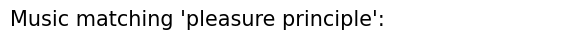

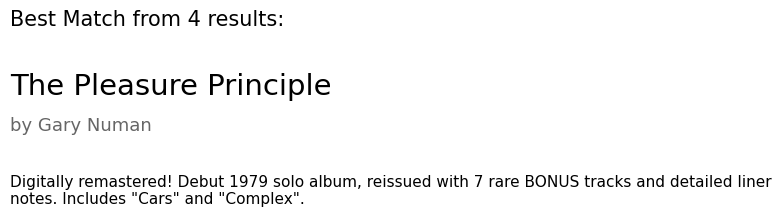

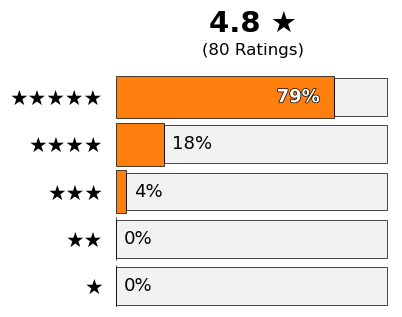

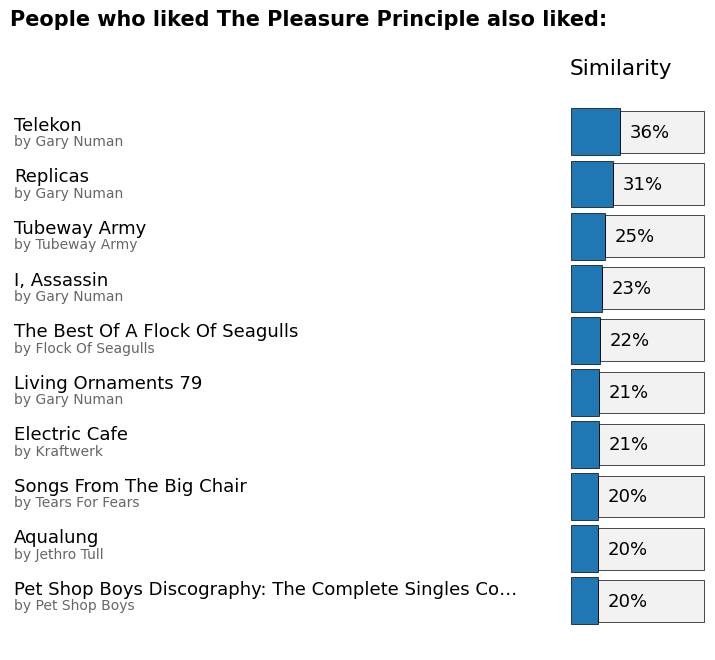

In [63]:
# Search input. These are intended as user-facing inputs.
type = 'Album' # possibilities: Book, Album, Artist, Author
search = 'pleasure principle'
exact_match = True

# recommender settings
# feel free to experiment with these to see how results change.
max_search_results = 10 # Relevant in case of ambiguous search terms with multiple hits. Presto will resolve ambiguity by selecting the most-reviewd product
max_recommendations = 10 # How many of Presto's related products to display to the usser
recommender_user_pool_size = 100 # For large numbers of user reviews, consider only this many users for recommendations. Filters by users who leave the most reviews.
recommender_product_pool_size = 100 # For large numbers of user reviews, consider only this many products for recommendations. Filters by number of reviews

log_verbosity = 1 # Increase to see internal details
include_subtitles = True

###################################
# Recommendations
##################################
results = output_recommendations(type, search, exact_match, conn = conn, include_subtitles = include_subtitles)
print('\n')

## Internal Details

This section is for tech-savvy readers who are interested in more details on how Presto! determined its user-facing results. To arrive at a product and recommendation, Presto!'s process is to:

- Conduct a robust search that includes:
    - Case insensitivity (e.g. 'adele' matches 'Adele')
    - Punctuation insensitivity (e.g. 'Dr Seuss' matches 'Dr. Seuss')
    - Diacritic insensitivity (e.g. 'Celine Dion' matches 'Céline Dion')
    - Article insensitivity (e.g. 'Who' matches 'The Who')
    - Name ordering insensitivity (e.g. 'George Orwell' matches 'Orwell, George')
- Disambiguate between multiple search results
    - E.g. 'The Pleasure Principle' matches albums by Gary Numan, Janet Jackson, and more
- Find all related products and reviews (products reviewed by the reviewers of the target product)
- Filter for the best related reviews
- Use [**cosine similarity**](https://en.wikipedia.org/wiki/Cosine_similarity) to find products whose reviewer patterns most closely match the searched product

In [30]:
# Explore the internals of the results in more detail if needed:
product = results['result']
products = results['results']
recommendations = results['recommendations']
reviews = results['reviews']

print('All search results:')
products

All search results:


,id,reviews,title,creator,publisher,description,release_date,category,subcategory
0,B000006NTW,80,The Pleasure Principle,Gary Numan,,"Digitally remastered! Debut 1979 solo album, r...","April 30, 2006",Music,
2,B00D6ZCTX2,8,Pleasure Principle,Parlet,,"Of George Clinton's two girl groups, The Bride...","June 5, 2013",Music,
3,B00005MHPK,4,The Pleasure Principle,Treat,,Wellness version.,"February 11, 2007",Music,
6,B002DM3Y10,1,The Pleasure Principle,Janet Jackson,,,"February 11, 2011",Music,


In [32]:
print('Selected search result:')
product

Selected search result:


id                                                     B000006NTW
reviews                                                        80
title                                      The Pleasure Principle
creator                                                Gary Numan
publisher                                                        
description     Digitally remastered! Debut 1979 solo album, r...
release_date                                       April 30, 2006
category                                                    Music
subcategory                                                      
Name: 0, dtype: object

In [34]:
print('Product recommendation details:')
recommendations

Product recommendation details:


,similarity,title,creator,publisher,description,category,subcategory,release_date
B000006NTP,0.361135,Telekon,Gary Numan,,Gary Numan - Telekon - CD,Music,,"December 7, 2006"
B00000I2B0,0.313260,Replicas,Gary Numan,,"Product Description, Original UK Album plus Si...",Music,,"April 30, 2006"
B000006NTM,0.249872,Tubeway Army,Tubeway Army,,,Music,,None
B00006J677,0.229801,"I, Assassin",Gary Numan,,"Product description, N/A, Review, Even the mos...",Music,,"February 13, 2007"
B0000004U8,0.216313,The Best Of A Flock Of Seagulls,Flock Of Seagulls,,"Product description, No Description AvailableN...",Music,,"December 7, 2006"
...,...,...,...,...,...,...,...,...
B000002BVW,0.149772,Oxygene 7-13,Jean Michel Jarre Madonna,,,Music,,"February 10, 2007"
B0000085CV,0.148928,Living Ornaments 81,Gary Numan,,,Music,,"January 29, 2007"
B0025KVLT2,0.148928,Rubber Soul,The Beatles,,The classic original Beatles studio albums hav...,Music,,"April 8, 2009"
B000002LRT,0.148928,Shepherd Moons,Enya,,"Product Description, Certified 5 times platinu...",Music,,"December 12, 2006"


Finally, let's share visualizations for the core of Presto!'s recommendations - finding products with reviewer patterns similar to the searched product.

First, Presto finds all user ratings for products that have a reviewer in common with the target product. This leads to a potentially large matrix of user ratings by product:

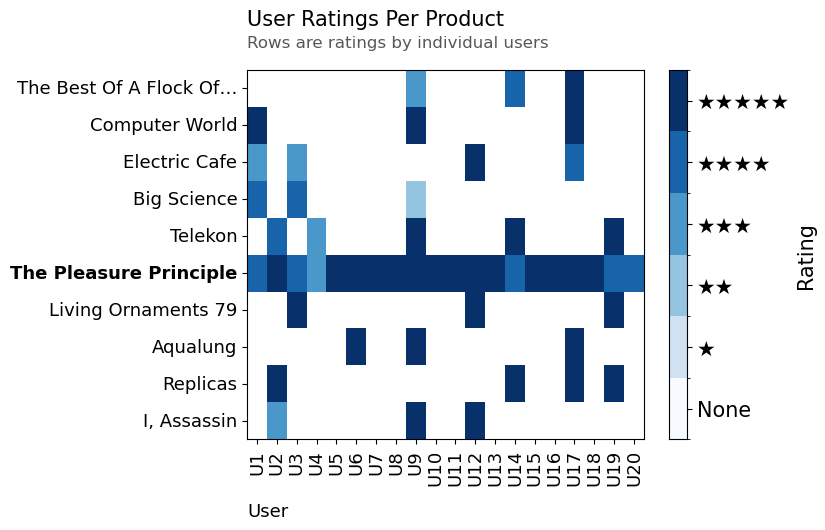

In [37]:
from presto.shared import viz

# Note: for the sake of visualization, we limit the size of the data that Presto! crunches for recommendations - the user-facing algorithm may use matrices that are too large to visualize.
demo_product_limit = 10
demo_user_limit = 20
title_limit = max(len(search), 20)

related_reviews = q.get_related_reviews(
    reviews,
    conn,
    filter_unhelpful_reviews = False,
    max_reviewer_count = demo_user_limit, max_product_count = demo_product_limit,
    verbosity = 0
)
user_ratings_per_product = q.get_ratings_by_user(related_reviews)    
product_names = q.get_product_details(user_ratings_per_product.index, conn = conn, select = 'title', verbosity = 0)['title']
user_ratings_per_product.index = product_names

viz.plot_user_ratings_by_product(user_ratings_per_product, product.title, conn, product_name_limit = title_limit);

The above is likely a small sample of representative products and reviews used by Presto!'s recommendation algorithm for the sake of visualization - the full matrix of common products and reviews may be thousands of items in each dimension.

After finding representative related reviews, Presto! uses **cosine similarity** to calculate the pairwise similarities between each pair of two products:

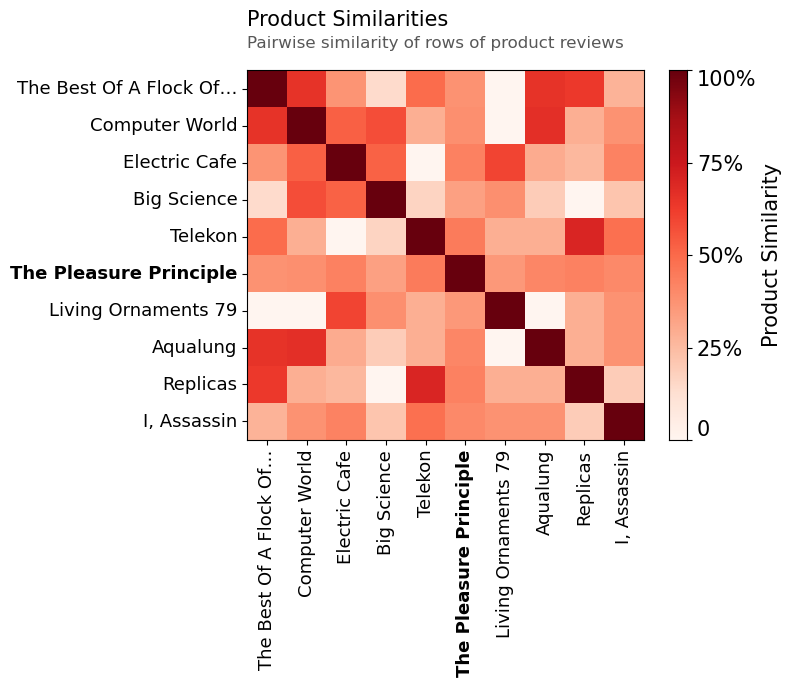

In [40]:
similarities = q.get_pairwise_similarities(user_ratings_per_product)
products = user_ratings_per_product.index.values
similarities = pd.DataFrame(similarities, index = products, columns = products)
viz.plot_pairwise_similarities(similarities, product.title, conn, product_name_limit = title_limit);

In [42]:
# Don't forget to clean up
conn.close()